In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [3]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.coupled_momentum_observation import CoupledMomentumObservation, CoupledMomentumTransformation
from project_ssms.momentum_utils import filter_traj_by_speed
from project_ssms.utils import k_step_prediction_for_coupled_momentum_model

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# data

In [5]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

session_data = datasets_processed[0].render_trajectories([3,8])
traj0 = np.concatenate((session_data), axis=1)

In [6]:
del datasets_processed

In [7]:
del session_data

In [8]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

In [9]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

WATER = torch.tensor([50, 50], dtype=torch.float64)
FOOD = torch.tensor([270, 50], dtype=torch.float64)
NEST = torch.tensor([270, 330], dtype=torch.float64)
CORNER = torch.tensor([50, 330], dtype=torch.float64)

# model

$$ x_t \sim x_{t-1} +  2 * \sigma(\alpha_k) m_t + v_{max} \sigma(W_k x_{t-1} + b_k))  \qquad | \qquad z_t =k$$ 

where

- $m_t$ is the momentum vector, obtained by applying a (weighted) linear regression to the past #lags observations, and scaling the fitted vector by 1/#lags.
- $v_{max}$ = 6
- features here are:
     - unit_vector_to_other,
     - lambda s, o: unit_vector_to_fixed_loc(s, o, WATER),
     - lambda s, o: unit_vector_to_fixed_loc(s, o, NEST),
     - lambda s, o: unit_vector_to_fixed_loc(s, o, FOOD),
     - lambda s, o: unit_vector_to_fixed_loc(s, o, CORNER),


In [10]:
momentum_lags = 30
momentum_weights = np.arange(0.55, 2.05, 0.05)

In [11]:
torch.manual_seed(0)
np.random.seed(0)

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

max_v = np.array([5.0, 5.0, 5.0, 5.0])

acc_factor=2

K = 2
D = 4
T = 36000

observation = CoupledMomentumObservation(K=K, D=D, M=0, bounds=bounds, 
                                         momentum_lags=momentum_lags,momentum_weights=momentum_weights,
                                         max_v=max_v, acc_factor=acc_factor)


model = HMM(K=K, D=D, M=0, observation=observation)
m_tran = model.observation.transformation

In [12]:
data = torch.tensor(f_traj, dtype=torch.float64)

In [14]:
momentum_vecs = CoupledMomentumTransformation._compute_momentum_vecs(data[:-1],
                                                                     lags=momentum_lags, 
                                                                     weights=momentum_weights)

In [33]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [20]:
model.log_likelihood(data, momentum_vecs=momentum_vecs)

tensor(-2078158.9465, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

# training

In [21]:
##################### training ############################

num_iters = 5000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, momentum_vecs=momentum_vecs)

iter 4990 loss 441710.40: 100%|██████████| 5000/5000 [30:03<00:00,  2.45it/s]  | 0/5000 [00:00<?, ?it/s]


In [34]:
num_iters = 3000
losses_1, opt_1 = model.fit(data, num_iters=num_iters, lr=0.001, momentum_vecs=momentum_vecs)

iter 2990 loss 441694.05: 100%|██████████| 3000/3000 [18:32<00:00,  2.57it/s] | 0/3000 [00:00<?, ?it/s]


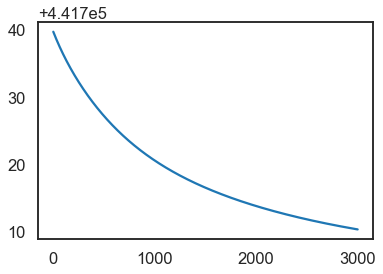

In [37]:
plt.plot(losses[2000:])

# samples

In [24]:
sample_z, sample_x = model.sample(T)

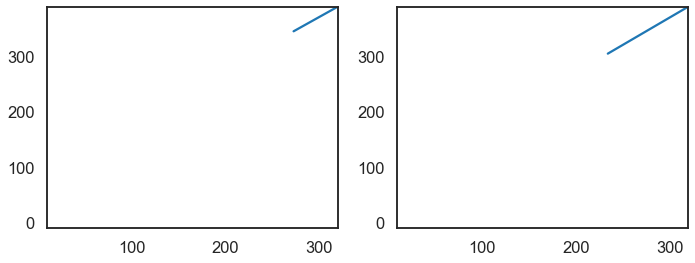

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:,0], sample_x[:,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.subplot(1,2,2)
plt.plot(sample_x[:,2], sample_x[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

plt.tight_layout()

In [26]:
model.observation.mus_init =torch.tensor([150, 170, 150, 170], dtype=torch.float64)

In [27]:
sample_z, sample_x = model.sample(T)

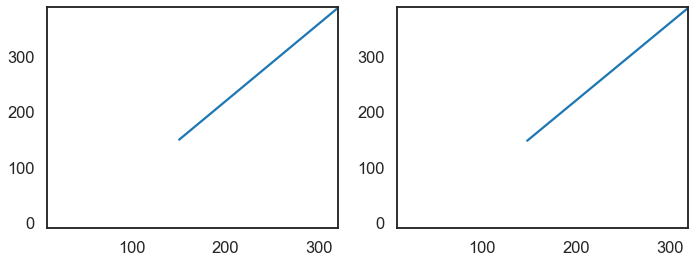

In [28]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(sample_x[:,0], sample_x[:,1])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)
plt.subplot(1,2,2)
plt.plot(sample_x[:,2], sample_x[:,3])
plt.xlim(arena_xmin, arena_xmax)
plt.ylim(arena_ymin, arena_ymax)

plt.tight_layout()